In [7]:
import mnist
import gurobipy as gp
import numpy as np
from itertools import product

def cost(i,j):
    row_1 = j % 28
    col_1 = j // 28
    row_2 = i % 28
    col_2 = i // 28
    
    return ((row_1 - row_2) ** 2) + ((col_1 - col_2) ** 2)

x_train, t_train, x_test, t_test = mnist.load()

x_train_norm = x_train / np.sum(x_train, axis = 1)[:,None]

In [17]:
from PIL import Image

Image.fromarray(x_train[9,:].reshape(28,28))

In [18]:
imgs = x_train_norm[np.where(t_train == 0)[0][:10]]

In [14]:
model = gp.Model()

model.setParam(gp.GRB.Param.Method, 2)
model.setParam(gp.GRB.Param.NumericFocus, 1)
model.setParam(gp.GRB.Param.OutputFlag, 1)
model.setParam(gp.GRB.Param.Crossover, 0)
model.setAttr(gp.GRB.Attr.ModelSense, 1)

num_dists = len(imgs) # number of images
num_support = x_train_norm[0].shape[0] # vector size of image

x = model.addVars(num_support, num_support, num_dists, lb = 0.0)
y = model.addVars(num_support, lb = 0.0)

Set parameter Method to value 2
Set parameter NumericFocus to value 1
Set parameter Crossover to value 0


In [15]:
model.reset()
model.remove(model.getConstrs())

for i, k in product(range(num_support), range(num_dists)):
    model.addConstr(x.sum(i,'*',k) == imgs[k,i])
    
for j, k in product(range(num_support), range(num_dists)):
    model.addConstr(x.sum('*',j,k) == y[j])
    
model.addConstr(y.sum() == 1)

model.setObjective(gp.quicksum(x[i,j,k] * cost(i,j) for i,j,k in product(range(num_support), range(num_support), range(num_dists))))

model.optimize()

Discarded solution information
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 15681 rows, 6147344 columns and 12301744 nonzeros
Model fingerprint: 0x334fc2ad
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-05, 1e+00]
Presolve removed 5854 rows and 4589536 columns
Presolve time: 2.12s
Presolved: 9827 rows, 1557808 columns, 3122672 nonzeros
Ordering time: 0.53s
Ordering time: 0.82s

Barrier statistics:
 Dense cols : 695
 AA' NZ     : 1.570e+06
 Factor NZ  : 6.671e+06 (roughly 700 MB of memory)
 Factor Ops : 1.005e+10 (less than 1 second per iteration)
 Threads    : 12

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.91737207e+07  0.00000000e+00  7.84e+01 0.00e+00 

In [9]:
barycenter = np.zeros(num_support)
for j in range(num_support):
    barycenter[j] = y[j].X

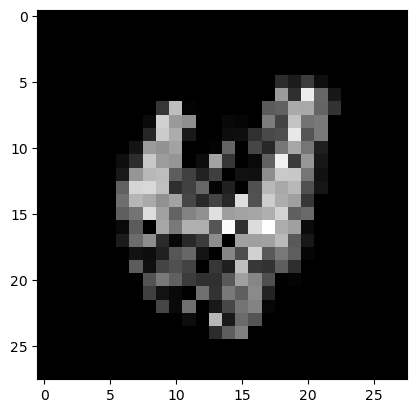

In [11]:
import matplotlib.pyplot as plt

plt.imshow(barycenter.reshape(28,28), cmap='gray')

In [ ]:
from scipy.optimize import linear_sum_assignment
cost_mat = np.zeros(784,784)
for i, j in product(range(784), range(784)):
    cost_mat[i,j] = cost(i,j)

def wasserstein_imgs(img1, img2, cost_mat):
    """
    Here, we assume they are both 28x28 normalized images
    in flattened format.
    """
    